In [1]:
def give_me_df(ticker):
    import yfinance as yf
    import pandas as pd
    stock = yf.Ticker(ticker)
    df = stock.history(period='max')
    df[ticker] = df.Close.pct_change()
    return df[[ticker]].iloc[1:]

In [2]:
df1 = give_me_df('SPY') 
df2 = give_me_df('AAPL') 
df3 = give_me_df('FB') 

In [3]:
def join_dfs(*dfs):
    import pandas as pd
    for idx, df_ in enumerate(dfs):
        if idx == 0:
            df = df_
        else:
            df = df.join(df_, how='inner')
    return df

In [4]:
df = join_dfs(df1, df2, df3)

In [5]:
def train_test_split(df, test_size_ratio=0.3):
    import pandas as pd
    import numpy as np
    num_data = df.shape[0]
    num_data_train = int(num_data * (1-test_size_ratio)) 
    xy_train = df.iloc[:num_data_train].values
    xy_test = df.iloc[num_data_train:].values
    x_train = xy_train[:,:-1].astype(np.float32)
    y_train = xy_train[:,-1].astype(np.float32).reshape((-1,1))
    x_test = xy_test[:,:-1].astype(np.float32)
    y_test = xy_test[:,-1].astype(np.float32).reshape((-1,1))
    return x_train, y_train, x_test, y_test

In [6]:
x_train, y_train, x_test, y_test = train_test_split(df) 
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print(x_train.dtype, y_train.dtype, x_test.dtype, y_test.dtype)

(1489, 2) (1489, 1) (639, 2) (639, 1)
float32 float32 float32 float32


In [8]:
import tensorflow as tf
tf.reset_default_graph()

x = tf.placeholder(tf.float32, (None, 2), name='x') # (?, 2)
y = tf.placeholder(tf.float32, (None), name='y')

init_w = tf.keras.initializers.VarianceScaling(seed=0)
w = tf.get_variable('w', (2,), tf.float32, init_w) # (2,)

init_b = tf.keras.initializers.zeros()
b = tf.get_variable('b', (), tf.float32, init_b)

try:
    y_pred = x @ w + b # (?, 2) @ (2,) 
except ValueError as e:
    print(e)
    print('메트릭스 멀티플리케이션이 작동불능')

Shape must be rank 2 but is rank 1 for 'matmul' (op: 'MatMul') with input shapes: [?,2], [2].
메트릭스 멀티플리케이션이 작동불능


In [20]:
import tensorflow as tf
tf.reset_default_graph()

x = tf.placeholder(tf.float32, (None, 2), name='x') # (?, 2)
y = tf.placeholder(tf.float32, (None, 1), name='y') # (?, 1)

init_w = tf.keras.initializers.VarianceScaling(seed=0)
w = tf.get_variable('w', (2, 1), tf.float32, init_w) # (2, 1)

init_b = tf.keras.initializers.zeros()
b = tf.get_variable('b', (), tf.float32, init_b) # ()

y_pred = x @ w + b # (?, 2) @ (2, 1) + () = (?, 1) + () = (?, 1)

diff = y - y_pred # (?, 1) - (?, 1) = (?, 1)
loss = tf.nn.l2_loss(diff) # ()

print(diff.shape, loss.shape)
print(diff.dtype, loss.dtype)

(?, 1) ()
<dtype: 'float32'> <dtype: 'float32'>


In [28]:
import tensorflow as tf
tf.reset_default_graph()

x = tf.placeholder(tf.float32, (None, 2), name='x')
y = tf.placeholder(tf.float32, (None, 1), name='y')

init_w = tf.keras.initializers.VarianceScaling(seed=0)
w = tf.get_variable('w', (2, 1), tf.float32, init_w)

init_b = tf.keras.initializers.zeros()
b = tf.get_variable('b', (), tf.float32, init_b)

y_pred = x @ w + b # (None, 2) @ (2, 1) = (None, 1)

diff = y - y_pred
loss = tf.nn.l2_loss(diff)

loss_w, loss_b  = tf.gradients(loss, [w, b])

train = [tf.assign(w, w - lr * loss_w), tf.assign(b, b - lr * loss_b)]

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    feed_dict = {x: x_train, y: y_train}
    print(sess.run([loss, loss_w, loss_b], feed_dict=feed_dict))

[0.42124256, array([[-0.1151835 ],
       [-0.10883532]], dtype=float32), -1.9513377]


In [57]:
lr = 1e-3
epoch = int(1e5)

import tensorflow as tf
tf.reset_default_graph()

x = tf.placeholder(tf.float32, (None, 2), name='x')
y = tf.placeholder(tf.float32, (None, 1), name='y')

init_w = tf.keras.initializers.VarianceScaling(seed=0)
w = tf.get_variable('w', (2, 1), tf.float32, init_w)

init_b = tf.keras.initializers.zeros()
b = tf.get_variable('b', (), tf.float32, init_b)

y_pred = x @ w + b # (None, 2) @ (2, 1) = (None, 1)

diff = y - y_pred
loss = tf.nn.l2_loss(diff)

loss_w, loss_b = tf.gradients(loss, [w, b])

train = [tf.assign(w, w - lr * loss_w), tf.assign(b, b - lr * loss_b)]

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    feed_dict = {x: x_train, y: y_train}
    loss_trace = []
    w0_trace = []
    w1_trace = []
    b_trace = []
    for i in range(epoch):
        _, loss_run, w_run, b_run = sess.run([train, loss, w, b],
                                             feed_dict=feed_dict)
        loss_trace.append(loss_run)
        w0_trace.append(w_run[0,0])
        w1_trace.append(w_run[1,0])
        b_trace.append(b_run)
        if i%int(epoch/10)==0:
            print(f'{i+1}/{epoch} : {loss_run}')
        if i==(epoch-1):
            print(f'{i+1}/{epoch} : {loss_run}')
            
    w_trained, b_trained = sess.run([w, b]) 

1/100000 : 0.4212425649166107
10001/100000 : 0.36246925592422485
20001/100000 : 0.3528771698474884
30001/100000 : 0.3500916063785553
40001/100000 : 0.3492817282676697
50001/100000 : 0.3490462005138397
60001/100000 : 0.3489777445793152
70001/100000 : 0.3489578664302826
80001/100000 : 0.348952054977417
90001/100000 : 0.3489503562450409
100000/100000 : 0.3489498794078827


In [31]:
lr = 1e-3
epoch = int(1e5)

import tensorflow as tf
tf.reset_default_graph()

x = tf.placeholder(tf.float32, (None, 2), name='x')
y = tf.placeholder(tf.float32, (None, 1), name='y')

init_w = tf.keras.initializers.VarianceScaling(seed=0)
w = tf.get_variable('w', (2, 1), tf.float32, init_w)

init_b = tf.keras.initializers.zeros()
b = tf.get_variable('b', (), tf.float32, init_b)

y_pred = x @ w + b # (None, 2) @ (2, 1) = (None, 1)

diff = y - y_pred
loss = tf.nn.l2_loss(diff)

if 0:
    loss_w, loss_b = tf.gradients(loss, [w, b])
    train = [tf.assign(w, w - lr * loss_w), tf.assign(b, b - lr * loss_b)]
elif 0:
    opt = tf.train.GradientDescentOptimizer(lr)
    train = opt.minimize(loss)
elif 0:
    opt = tf.train.RMSPropOptimizer(lr)
    train = opt.minimize(loss)
elif 0:
    opt = tf.train.AdagradOptimizer(lr)
    train = opt.minimize(loss)
elif 0:
    opt = tf.train.AdamOptimizer(lr, beta1=0.9, beta2=0.999, epsilon=1e-8)
    train = opt.minimize(loss)
# tf.train.AdagradOptimizer
# tf.train.RMSPropOptimizer

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    feed_dict = {x: x_train, y: y_train}
    loss_trace = []
    w0_trace = []
    w1_trace = []
    b_trace = []
    for i in range(epoch):
        _, loss_run, w_run, b_run = sess.run([train, loss, w, b],
                                             feed_dict=feed_dict)
        loss_trace.append(loss_run)
        w0_trace.append(w_run[0,0])
        w1_trace.append(w_run[1,0])
        b_trace.append(b_run)
        if i%int(epoch/10)==0:
            print(f'{i+1}/{epoch} : {loss_run}')
        if i==(epoch-1):
            print(f'{i+1}/{epoch} : {loss_run}')
            
    w_trained, b_trained = sess.run([w, b]) 

TypeError: __init__() missing 1 required positional argument: 'momentum'

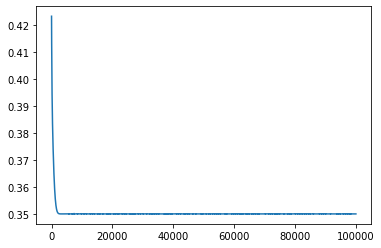

In [21]:
import matplotlib.pyplot as plt
plt.plot(loss_trace)
plt.show()

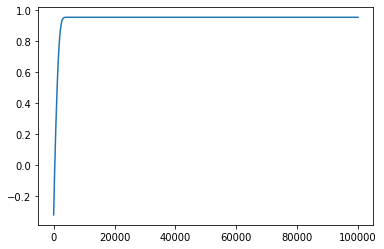

In [22]:
import matplotlib.pyplot as plt
plt.plot(w0_trace)
plt.show()

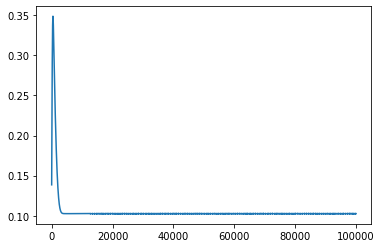

In [23]:
import matplotlib.pyplot as plt
plt.plot(w1_trace)
plt.show()

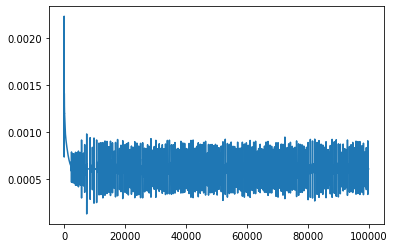

In [24]:
import matplotlib.pyplot as plt
plt.plot(b_trace)
plt.show()

In [25]:
with tf.Session() as sess:
    feed_dict = {x: x_train, w: w_trained, b: b_trained}
    y_train_pred = sess.run(y_pred, feed_dict=feed_dict)

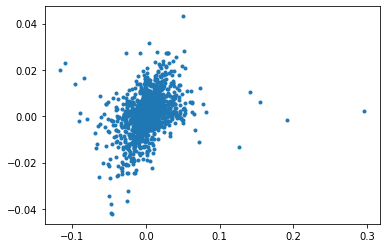

In [26]:
import matplotlib.pyplot as plt
plt.plot(y_train.reshape((-1,)), y_train_pred.reshape((-1,)), '.')
plt.show()

In [27]:
with tf.Session() as sess:
    feed_dict = {x: x_test, w: w_trained, b: b_trained}
    y_test_pred = sess.run(y_pred, feed_dict=feed_dict)

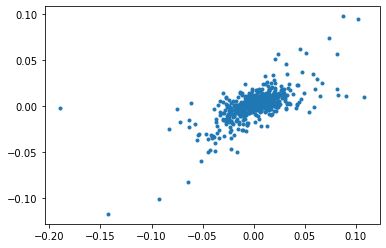

In [28]:
import matplotlib.pyplot as plt
plt.plot(y_test.reshape((-1,)), y_test_pred.reshape((-1,)), '.')
plt.show()